# SARSA semi-gradiente
Este notebook documenta un experimento de aprendizaje por refuerzo que emplea el algoritmo SARSA semi-gradient. En este enfoque, el agente utiliza una función aproximada basada en una red neuronal para estimar la función Q de forma continua, permitiendo actualizar sus parámetros mediante el gradiente del error TD de manera on-policy. El objetivo del experimento es entrenar un agente para balancear el poste en el entorno 'CartPole-v1' de Gymnasium, donde el reto consiste en mantener el poste en posición vertical durante el mayor tiempo posible. En el notebook se detalla la implementación de la política epsilon-greedy, la estructura de la red neuronal, el proceso de actualización de parámetros y el análisis de los resultados obtenidos durante el entrenamiento y la evaluación.

## Preparación del entorno
La preparación consta de las siguientes partes:

* **Instalación del Github**: Para hacer uso de clases y herencia, instalamos el repostiroio de github, donde tenemos implementrado todo el código.

* **Instalación de Dependencias**: Se instalan las librerías necesarias para utilizar el entorno gymnasium para la simulación, con el objetivo de crear un ambiente controlado para que el agente pueda interactuar.

* **Importación de Librerías**: Se importan las bibliotecas necesarias como numpy para el manejo de matrices y matplotlib para la visualización de los resultados.

* **Implantación de semilla**: Para poder replicar los resultados, implantamos una semilla para todos los procesos random implicados.

* **Importación del Entorno CartPole**: Se carga el entorno CartPole.

In [1]:
!git clone https://github.com/Imartinezcuevas/RL_MC_OL.git

fatal: la ruta de destino 'RL_MC_OL' ya existe y no es un directorio vacío.


In [ ]:
import sys

sys.path.append('/content/RL_MC_OL/src')
print(sys.path)

import numpy as np
from tqdm import tqdm
import gymnasium as gym
import random
import torch
import gc
import os

from agentes import SARSASemiGradientAgent
from politicas import EpsilonGreedyPolicy
from plotting import plot_training_comparation

['/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/antonio/.local/lib/python3.10/site-packages', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', 'src']


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Liberación de memoria para evitar problemas de consumo en GPU
gc.collect() # Ejecuta el recolector de basura de Python
torch.cuda.empty_cache() # Vacía la caché de memoria en GPU

# Depuración de errores en CUDA
os.environ['CUDA_LAUNCH_BLOCKING'] = '1' # Muestra errores de CUDA en el punto exacto donde ocurren

seed_value= 100
random.seed(seed_value)
np.random.seed(seed_value)
np.random.default_rng(seed_value) # Establece una instancia del generador de NumPy con la misma semilla

os.environ['PYTHONHASHSEED'] = str(seed_value)
torch.manual_seed(seed_value) 

if torch.cuda.is_available(): # Si hay GPU disponible
    torch.cuda.manual_seed(seed_value) # Fija la semilla para la GPU
    torch.backends.cudnn.deterministic = True # Hace las operaciones de CUDNN determinísticas
    torch.backends.cudnn.benchmark = False # Desactiva optimizaciones de CUDNN para evitar variabilidad

Usando dispositivo: cpu


In [3]:
name = 'CartPole-v1'
env = gym.make(name)
env.reset(seed=seed_value)

(array([ 0.03349816,  0.0096554 , -0.02111368, -0.04570484], dtype=float32),
 {})

## Componentes Clave

SARSA Semi-gradient es un algoritmo de aprendizaje por refuerzo on-policy que utiliza aproximadores de función, generalmente redes neuronales, para estimar la función Q. En este método, el agente actualiza los parámetros del aproximador de forma continua, empleando el gradiente descendiente aplicado al error TD calculado en cada transición. Este enfoque resulta especialmente útil para entornos con espacios de estado o acción de alta dimensionalidad o continuos.

1.  Agente (Agent, SarsaSemiGradientAgent):
    *   La clase `Agent` define la estructura base de un agente de RL.
    *   SarsaSemiGradientAgent implementa el algoritmo SARSA semi-gradient, utilizando un aproximador para representar la función Q y actualizando sus parámetros a partir del error TD en cada transición.      

2. Política (Policy, EpsilonGreedyPolicy):
    * La clase `Policy` define la estructura general de una política.
    * `EpsilonGreedyPolicy` implementa una política epsilon-greedy, que equilibra la exploración y la explotación: la acción de mayor valor Q se selecciona con alta probabilidad, mientras que ocasionalmente se eligen acciones aleatorias para explorar nuevas posibilidades.

3. Entorno (`gym.Env`):
    * El entorno de Gymnasium donde el agente interactua.
    * En este experimento se utiliza el entorno CartPole-v1, un escenario clásico en el que el agente debe aprender a mantener el equilibrio de un poste montado sobre un carro en movimiento, maximizando el tiempo en el que el poste se mantiene vertical.

## Función de entrenamiento

Se ha modificado el bucle de entrenamiento de referencia para emplear el algoritmo SARSA semi-gradient. En este caso, la función `train_agent` simula múltiples episodios de interacción entre el agente y el entorno, actualizando el agente en cada transición de forma on-policy mediante la actualización del aproximador (red neuronal) utilizando el gradiente del error TD. Además, se evalúa periódicamente el rendimiento del agente para monitorizar la evolución de la política y la estabilidad del aprendizaje.

In [4]:
def train_agent(agent, env, episodes=500, max_steps=500):
    """
    Función de entrenamiento basada en episodios.
    Actualiza la barra de progreso con estadísticas resumidas en lugar de imprimir en cada episodio.
    """
    episode_rewards = []
    episode_lengths = []
    
    progress_bar = tqdm(range(episodes), desc="Entrenando episodios", unit="ep")
    
    for ep in progress_bar:
        state, _ = env.reset()
        agent.start_episode()
        total_reward = 0
        
        for step in range(max_steps):
            action = agent.get_action(state)
            next_state, reward, done, truncated, info = env.step(action)
            agent.update(state, action, next_state, reward, done, info)
            total_reward += reward
            state = next_state
            if done or truncated:
                break
        
        agent.end_episode(total_reward, step + 1)
        episode_rewards.append(total_reward)
        episode_lengths.append(step + 1)
        
        # Aplica decaimiento de epsilon si la política lo soporta
        if hasattr(agent.policy, 'decay_epsilon'):
            agent.policy.decay_epsilon()
        
        # Actualiza la barra de progreso con estadísticas resumidas
        progress_bar.set_postfix({
            "Recompensa": f"{total_reward:.1f}",
            "Pasos": step + 1,
            "Epsilon": f"{agent.policy.epsilon:.4f}"
        })
        
    return episode_rewards, episode_lengths

## Función de evaluación
La función `evaluate_agent` evalúa el rendimiento del agente SARSA semi-gradient ejecutando múltiples episodios en modo determinista. Durante la evaluación se registran métricas clave como la tasa de éxito, la longitud promedio de los episodios y la recompensa promedio. Esto permite analizar de forma cuantitativa cómo el agente, que actualiza continuamente su aproximador mediante gradiente descendiente, se desempeña en entornos como CartPole-v1.

In [5]:
def evaluate_agent(agent, env, episodes=10, max_steps=500):
    """
    Función de evaluación: ejecuta el agente sin actualizarlo y muestra la recompensa de cada episodio.
    """
    total_rewards = []
    for ep in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        for step in range(max_steps):
            # Se utiliza la política de selección (por lo general greedy)
            action = agent.policy.select_action(state, agent.get_action_values(state))
            next_state, reward, done, truncated, info = env.step(action)
            total_reward += reward
            state = next_state
            if done or truncated:
                break
        total_rewards.append(total_reward)
        print(f"Episodio de evaluación {ep+1}/{episodes} - Recompensa: {total_reward}")
    avg_reward = np.mean(total_rewards)
    print(f"Recompensa media en evaluación: {avg_reward:.1f}")
    return total_rewards

## Realizamos el entrenamiento

Entrenando episodios: 100%|██████████| 500/500 [02:20<00:00,  3.57ep/s, Recompensa=500.0, Pasos=500, Epsilon=0.0816]


Episodio de evaluación 1/10 - Recompensa: 500.0
Episodio de evaluación 2/10 - Recompensa: 500.0
Episodio de evaluación 3/10 - Recompensa: 500.0
Episodio de evaluación 4/10 - Recompensa: 500.0
Episodio de evaluación 5/10 - Recompensa: 500.0
Episodio de evaluación 6/10 - Recompensa: 500.0
Episodio de evaluación 7/10 - Recompensa: 500.0
Episodio de evaluación 8/10 - Recompensa: 500.0
Episodio de evaluación 9/10 - Recompensa: 500.0
Episodio de evaluación 10/10 - Recompensa: 500.0
Recompensa media en evaluación: 500.0


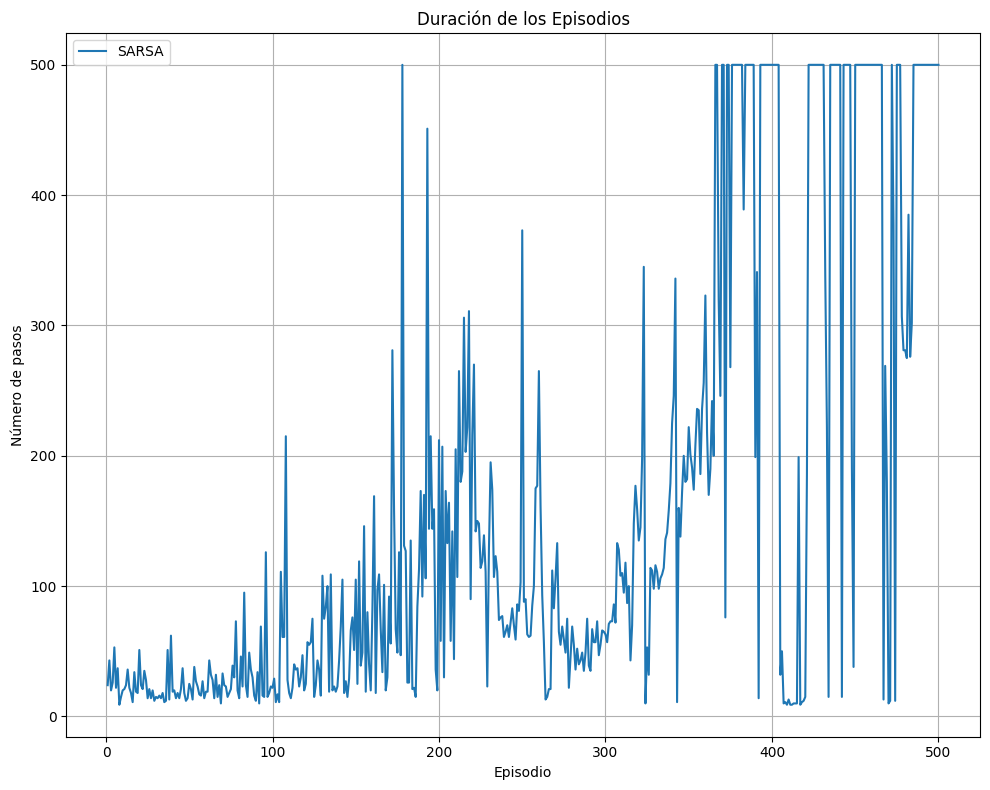

In [6]:
# Crear la política epsilon-greedy
policy = EpsilonGreedyPolicy(env.action_space, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01)
    
# Crear el agente SARSA Semi-gradient
agent = SARSASemiGradientAgent(
        env,
        policy=policy,
        gamma=0.99,
        lr=0.001
    )
    
# Entrenamiento
episode_rewards, episode_lengths = train_agent(agent, env, episodes=500, max_steps=500)
    
# Evaluación
evaluate_agent(agent, env, episodes=10, max_steps=500)
    
algorithms_data = {
        "SARSA": (episode_rewards, episode_lengths)
}
plot_training_comparation(algorithms_data, same=True)

## Resultados y conclusiones

1. Aprendizaje exitoso:
    * El agente logra mantener el poste en pie durante los 500 pasos máximos, tanto en los últimos episodios de entrenamiento como en todas las repeticiones de evaluación. Esto indica que la política aprendida es efectiva y que el agente ha alcanzado un rendimiento prácticamente óptimo para el entorno CartPole-v1.
2. Estabilidad en evaluación:
    *   Durante la evaluación, se observa que la recompensa en cada uno de los 10 episodios es de 500. En CartPole, esto significa que el agente no deja caer el poste y llega al límite máximo de pasos en cada episodio. Por tanto, el agente demuestra un comportamiento estable y consistente, sin episodios fallidos o con variabilidad.
3.  Convergencia del agente SARSA Semi-gradient:
    *   El hecho de alcanzar 500 pasos repetidamente sugiere que se ha ajustado adecuadamente a la dinámica del entorno. La tasa de aprendizaje y la configuración de exploración parecen haber sido correctas para lograr un equilibrio entre la exploración y la explotación.
4.  Evolución del epsilon:
    *   El valor de epsilon final (aproximadamente 0.0816) indica que, aunque todavía existe un pequeño porcentaje de exploración, no impide al agente mantener el poste en pie. Este nivel de exploración residual puede ayudar a evitar el sobreajuste a ciertas trayectorias, sin perjudicar el rendimiento en este entorno.
5.  Exploración residual:
    *   Aunque el agente ya haya aprendido una política casi óptima, el hecho de usar una política epsilon-greedy implica que, con cierta probabilidad, se elige una acción aleatoria. Esto puede provocar caídas tempranas en algunos episodios.

SARSA Semi-gradient, con los hiperparámetros elegidos, demuestra una excelente convergencia en CartPole-v1, alcanzando y sosteniendo el rendimiento máximo. Este resultado confirma la eficacia de los métodos on-policy con aproximación de funciones en entornos discretos relativamente simples y subraya que el agente ha aprendido la política óptima para el dominio evaluado.